In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [8]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 2: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 3: # 6:2:2
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)

  return train_data, test_data, val_data


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Project/dataset/NFLX_Stock.csv',usecols=['Date', 'Price'], parse_dates=['Date'], index_col='Date')
df.head()

,Price
Date,
2017-12-01,186.82
2017-12-04,184.04
2017-12-05,184.21
2017-12-06,185.30
2017-12-07,185.20


In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

train_data, test_data, val_data = split_data(scaled_data , 1)

Train:  974
Test:  278
Val:  140


In [10]:
n_steps = 10
n_features = 1

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Tạo input sequences cho training, validation, và testing
X_train, y_train = create_sequences(train_data, n_steps)
X_val, y_val = create_sequences(val_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

In [11]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#### TCN

In [12]:
def tcn():
  model = Sequential()
  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='causal', input_shape=(n_steps, n_features)))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=2))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=4))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=8))
  model.add(Flatten())
  model.add(Dense(1))

  return model

In [13]:
model = tcn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [14]:
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))#, metrics=[MeanAbsolutePercentageError()])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 12s 25ms/step - loss: 0.0563 - val_loss: 0.0226
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0073
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0068
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0110
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0056
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 10/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 1

##### GridSearch TCN

In [15]:
def build_tcn_model(activation):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation=activation, padding='causal', input_shape=(n_steps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation=activation))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation=activation, dilation_rate=2))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation=activation, dilation_rate=4))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation=activation, dilation_rate=8))
    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))

    return model

In [16]:
tcn_model = KerasRegressor(build_fn=build_tcn_model, verbose=0)
param_grid = {'activation': ['relu', 'tanh', 'sigmoid','LeakyReLU']}

grid_tcn = GridSearchCV(estimator=tcn_model, param_grid=param_grid, cv=3, error_score='raise')
grid_tcn_result = grid_tcn.fit(X_train, y_train)

best_activation = grid_tcn_result.best_params_['activation']
print(f'Best activation: {best_activation}')

<ipython-input-16-678638f71ac0>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  tcn_model = KerasRegressor(build_fn=build_tcn_model, verbose=0)


Best activation: tanh


In [17]:
model_best = build_tcn_model(best_activation)
history = model_best.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 3s 12ms/step - loss: 0.0236 - val_loss: 0.0064
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 11

##### Evaluation model

In [18]:
def evaluation_model(model):
  # evaluate trên tập test
  loss_test = model.evaluate(X_test, y_test, verbose=0)
  print("loss_test: ", loss_test)

  # evaluate trên tập val
  loss_val = model.evaluate(X_val, y_val, verbose=0)
  print("loss_val: ", loss_val)

In [19]:
evaluation_model(model)

loss_test:  0.0018251315923407674
loss_val:  0.0003028048959095031


In [20]:
evaluation_model(model_best)

loss_test:  0.0010953476885333657
loss_val:  0.0003074808046221733


In [21]:
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
y_val = scaler.inverse_transform(y_val)

In [22]:
def mae_rmse_mape(true, predict):
  mae = mean_absolute_error(true, predict)
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return mae, rmse, mape

In [25]:
def predict_future(model, number_days):
  last_sequence = X_val[-1:]
  predicted_values = []
  for _ in range(number_days):
    next_value = model.predict(last_sequence)
    predicted_values.append(next_value[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [next_value], axis=1)
  predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
  predicted_values = np.array(predicted_values).reshape(-1, 1)
  return predicted_values

In [24]:
def metrics(model):
  y_pred_test = model.predict(X_test)
  y_pred_val = model.predict(X_val)

  y_pred_test = scaler.inverse_transform(y_pred_test)
  y_pred_val = scaler.inverse_transform(y_pred_val)


  mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, y_pred_test)
  mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, y_pred_val)
# mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, model.predict(X_test))
# mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, model.predict(X_val))

  print('MAE of Test: ', mae_test)
  print('RMSE of Test: ', rmse_test)
  print('MAPE of Test: ', mape_test)
  print('------------------------')
  print('MAE of Validation: ', mae_val)
  print('RMSE of Validation: ', rmse_val)
  print('MAPE of Validation: ', mape_val)

In [26]:
metrics(model)

5/5 [==============================] - 0s 3ms/step
MAE of Test:  17.115870252011423
RMSE of Test:  22.44249269623378
MAPE of Test:  0.06129214992022299
------------------------
MAE of Validation:  7.149107074444111
RMSE of Validation:  9.141248192277384
MAPE of Validation:  0.02159703834849412


In [27]:
metrics(model_best)

5/5 [==============================] - 0s 3ms/step
MAE of Test:  12.260220507721401
RMSE of Test:  17.386010586212276
MAPE of Test:  0.04345150289458649
------------------------
MAE of Validation:  6.845285175030049
RMSE of Validation:  9.211556276424847
MAPE of Validation:  0.020547631446091046


##### Visualization TCN

In [28]:
number_days = 30

train_actual = scaler.inverse_transform(train_data.reshape(-1, 1))
val_actual = scaler.inverse_transform(val_data.reshape(-1, 1))
test_actual = scaler.inverse_transform(test_data.reshape(-1, 1))

# val_predictions = scaler.inverse_transform(model.predict(X_val))
# test_predictions = scaler.inverse_transform(model.predict(X_test))



# train_actual = train_data.reshape(-1, 1)
# val_actual = val_data.reshape(-1, 1)
# test_actual = test_data.reshape(-1, 1)

# val_predictions = model.predict(X_val)
# test_predictions = model.predict(X_test)

In [29]:
train_actual.shape, y_train.shape

((974, 1), (964, 1))

In [30]:
def visualization(model):
  y_pred_test = model.predict(X_test)
  y_pred_val = model.predict(X_val)

  y_pred_test = scaler.inverse_transform(y_pred_test)
  y_pred_val = scaler.inverse_transform(y_pred_val)

  plt.figure(figsize=(12,6))

  plt.plot(range(len(y_train)), y_train, label='Train')

  plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
  plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, label='Test Prediction')

  plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_val, label='Validation')
  plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_pred_val, label='Validation Prediction')

  # predicted_values = predict_future(model, number_days)
  # plt.plot(range(len(y_train) + len(y_test) + len(y_val), len(y_train) + len(y_test) + len(y_val) + number_days), predicted_values, label='30days_Next')

  plt.legend()
  plt.show()

5/5 [==============================] - 0s 4ms/step


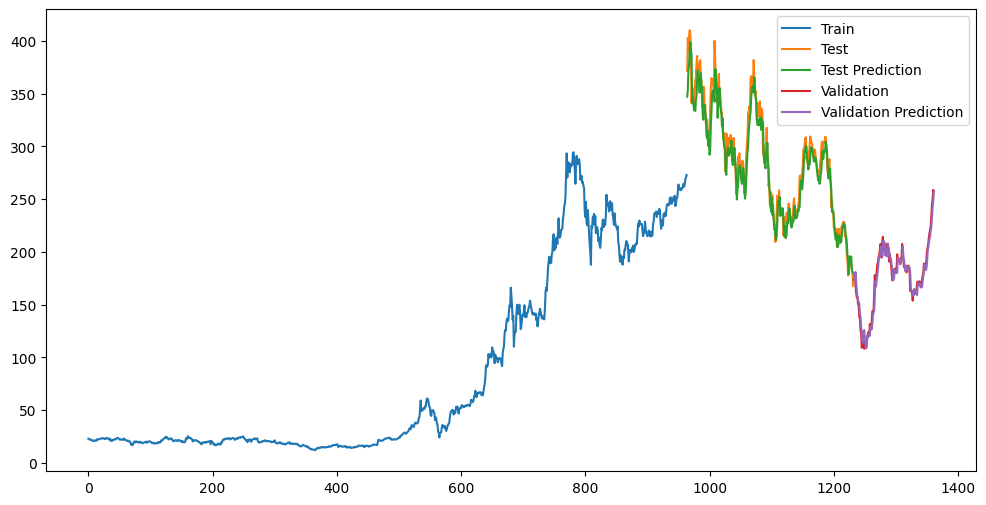

In [ ]:
visualization(model)

5/5 [==============================] - 0s 3ms/step


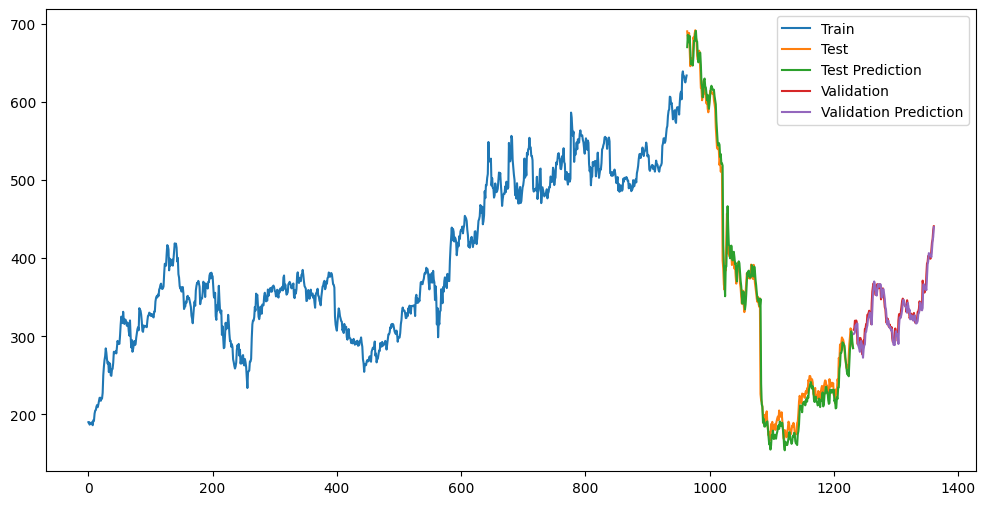

In [31]:
visualization(model_best)